In [126]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

In [127]:
%load_ext autoreload
%autoreload 2
#import CCPA_lib as cp
import sorf_lib as sf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
sns.set_context('talk')
sns.set_style('white')


![](http://oregonstate.edu/instruct/bb450/fall14/stryer7/2/table_02_02.jpg)

https://www.uniprot.org/uniprot/Q7V735

http://tigrfams.jcvi.org/cgi-bin/HmmReportPage.cgi?acc=TIGR03798

https://www.ebi.ac.uk/training/online/course/interpro-functional-and-structural-analysis-protei/sequence-searching/searching-interpro-batc

http://www.ebi.ac.uk/interpro/sequencesearch/iprscan5-S20190707-131508-0462-76111813-p1m

https://www.ebi.ac.uk/Tools/services/rest/iprscan5/result/iprscan5-S20190707-131508-0462-76111813-p1m/json

In [4]:
oorder = ['Intergenic', 'Antisense', 'Out of Frame','In Frame',  'Annotated', ]
opalette = sns.color_palette("rainbow", 5).as_hex()
#del opalette[4]

In [6]:
dpath = 'orffinder_tmp'
summary_suffix = '.sorf.summary.csv.gz'
sorf_result_suffix = '.sorf.feather.gz'

In [7]:
ccrg_excel_fname =  'ccrg and procm genes.xlsx'

In [8]:
protein_fname = r'Seq46351_QE2_specific-new-one peptide.xlsx'
protein_dpath = os.path.join('1A3','proteomics', 'with orfs DB')
protein_fpath = os.path.join(protein_dpath, protein_fname)

In [9]:
genome = 'MIT9313'

In [10]:
genome_df = pd.read_feather(os.path.join('data', f'{genome}.ncbi.gb.feather.gz'))


C:\Users\wosnat\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [11]:
ccrg_procm_df = pd.read_excel(os.path.join('data', ccrg_excel_fname), sheet_name='data')
ccrg_procm_df2 = pd.read_excel(os.path.join('data', ccrg_excel_fname), sheet_name='proc')

In [12]:
genome_df.head()

,contig_id,gene_id,pmt_id,type,location,strand,start,stop,left,right,function,genome,old_locus_tag,product,db_xref,protein_id,figfam,nucleotide_sequence,aa_sequence
0,MIT9313,AKG35_RS00005,PMT0001,CDS,AKG35_RS00005,+,173,1340,173,1340,DNA polymerase III subunit beta,MIT9313,"PMT0001,RG24_RS00005",DNA polymerase III subunit beta,GI:499441916,WP_011129380.1,,,MKLVCSQAELNTALQLVSRAVASRPTHPVLANVLLTADAGTDRLSL...
1,MIT9313,AKG35_RS00010,PMT0002,CDS,AKG35_RS00010,+,1343,2120,1343,2120,hypothetical protein,MIT9313,"PMT0002,RG24_RS00010",hypothetical protein,GI:752737102,WP_041384224.1,,,MNLPDQILLSDLLHHRVRCDQGLDHGPGVLPWMHPPVHRLLGWVSR...
2,MIT9313,AKG35_RS00015,PMT0003,CDS,AKG35_RS00015,+,2177,4562,2177,4562,phosphoribosylformylglycinamidine synthase sub...,MIT9313,"PMT0003,RG24_RS00015",phosphoribosylformylglycinamidine synthase sub...,GI:499441918,WP_011129382.1,,,MRVDYDVAAALRHEGLKPHDYDEICRRLQRAPNRVELGMFGVMWSE...
3,MIT9313,AKG35_RS00020,PMT0004,CDS,AKG35_RS00020,+,4621,6079,4621,6079,amidophosphoribosyltransferase,MIT9313,"PMT0004,RG24_RS00020",amidophosphoribosyltransferase,GI:499441919,WP_011129383.1,,,MCGIVGIVSTALVNQQIYDSLLLLQHRGQDSTGIATMDGSVFHLHK...
4,MIT9313,AKG35_RS00025,PMT0005,CDS,AKG35_RS00025,-,6114,8604,6114,8604,DNA topoisomerase 4 subunit A,MIT9313,"PMT0005,RG24_RS00025",DNA topoisomerase 4 subunit A,GI:499441920,WP_011129384.1,,,MAEERLQPIALHQEMQRSYLEYAMSVIVGRALPDARDGLKPVQRRI...


In [13]:
genome_df = pd.merge(genome_df, ccrg_procm_df, left_on='pmt_id', right_on='Gene', how='left' )

In [14]:
genome_df.loc[genome_df['product'].str.contains('CCRG-2'), 'family'] = 'CCRG-2'

In [15]:
genome_df.loc[genome_df['function'].isin(['Nif11-like leader peptide family natural product precursor', 
                                          'lantipeptide']),
              'family'
             ] = 'ProcA'

In [16]:
genome_df.loc[genome_df['family'] == 'CCRG-1', 'function'].unique()

array(['guanylate-binding protein'], dtype=object)

In [17]:
ccrg_procm_df.family.value_counts()

ProcA              29
CCRG-2             12
CCRG-1              3
ABC transporter     1
procM               1
Name: family, dtype: int64

In [18]:
genome_df.family.value_counts()

ProcA              35
CCRG-2             15
procM               1
ABC transporter     1
CCRG-1              1
Name: family, dtype: int64

In [19]:
ccrg_procm_df2.loc[~ccrg_procm_df2.pmt.isin(genome_df.pmt_id)]


,gene name,Cluster,serial number in cluster,accession,GI,left,right,strand,pmt,vimss id
1,ProcA1.1,1,1.0,NP_894080,33862520,277780,278052,-,PMT0247,567347
2,ProcA1.2,1,2.0,NP_894078,33862518,276160,276447,-,PMT0245,567345
5,ProcA1.5,1,5.0,NP_894075,33862515,274290,274553,-,PMT0242,567342
6,ProcA1.6,1,6.0,NP_894074,33862514,273356,273631,-,PMT0241,567341
8,ProcA2.1,2,1.0,NP_895958,33864398,2244664,2244945,-,PMT2134,569277
12,ProcA2.5,2,5.0,NP_895953,33864393,2242503,2242793,-,PMT2129,569272
15,ProcA2.8,2,8.0,NP_895946,33864386,2236027,2236278,-,PMT2122,569265
17,ProcA2.10,2,10.0,NP_895944,33864384,2235230,2235487,-,PMT2120,569263
18,ProcA2.11,2,11.0,NP_895943,33864383,2234897,2235151,-,PMT2119,569262
20,ProcA3.2,3,2.0,NP_894661,33863101,906436,906714,+,PMT0829,567941


In [20]:
def find_in_genome(x):
    found = genome_df.loc[(genome_df.left >= x.left-10) & (genome_df.right <= x.right + 10)]
    return found['family'].unique()
ccrg_procm_df2.loc[~ccrg_procm_df2.pmt.isin(genome_df.pmt_id)].apply(find_in_genome, axis=1)


1     [ProcA]
2     [ProcA]
5     [ProcA]
6     [ProcA]
8     [ProcA]
12    [ProcA]
15    [ProcA]
17    [ProcA]
18    [ProcA]
20    [ProcA]
23    [ProcA]
24    [ProcA]
27    [ProcA]
28    [ProcA]
29    [ProcA]
dtype: object

In [21]:
ccrg_procm_df.loc[~ccrg_procm_df.Gene.isin(genome_df.pmt_id) & ccrg_procm_df.family.isin(['CCRG-1', 'CCRG-2'])]

,family,Gene
1,CCRG-1,PMT0971
2,CCRG-1,PMT0885
3,CCRG-2,PMT0923
4,CCRG-2,PMT0928
6,CCRG-2,PMT2125
7,CCRG-2,P9313_26651
9,CCRG-2,P9313_26661
10,CCRG-2,P9313_02851


In [22]:
# ProcAs.2	s	2	NP_894719	33863159	969887	970183	+	PMT0887	567999
# ProcAs.1	s	1	NP_895437	33863877	1710816	1711142	+	PMT1610	568734
# ProcA4.4	4	4	NP_894754	33863194	1004342	1004653	-	PMT0922	568035
# CCRG1: PMT0971 1049007	1049402
# CCRG1: PMT0885 968520	968768
# CCRG2 1005678	1005340	-	PMT0923
# CCRG2 1010507	1010169	-	PMT0928
# CCRG2 2238151	2237804	-	PMT2125


genome_df.loc[(genome_df.start >= 1049000) & (genome_df.stop <= 1049402), 'family'] = 'CCRG-1'
genome_df.loc[(genome_df.start >= 968510) & (genome_df.stop <= 968780), 'family'] = 'CCRG-1'
genome_df.loc[(genome_df.start >= 1005320) & (genome_df.stop <= 1005700), 'family'] = 'CCRG-2'
genome_df.loc[(genome_df.start >= 1010150) & (genome_df.stop <= 1010520), 'family'] = 'CCRG-2'
genome_df.loc[(genome_df.start >= 2237800) & (genome_df.stop <= 2238160), 'family'] = 'CCRG-2'


In [23]:
genome_df.groupby(['family', 'function'])['contig_id', 'Gene'].count()

contig_id  \
family          function                                                        
ABC transporter ATP-binding cassette domain-containing protein              1   
CCRG-1          guanylate-binding protein                                   1   
                hypothetical protein                                        2   
CCRG-2          CCRG-2 family RiPP                                         12   
                CCRG-2 family protein                                       3   
                hypothetical protein                                        3   
ProcA           Nif11-like leader peptide family natural produc...         34   
                lantipeptide                                                1   
procM           lantipeptide-modifying enzyme LanM                          1   

                                                                    Gene  
family          function                                                  
ABC transporter ATP-binding cassette domain-containing protein         1  
CCRG-1          guanylate-binding protein                              1  
                hypothetical protein                                   0  
CCRG-2          CCRG-2 family RiPP                                     3  
                CCRG-2 family protein                                  3  
                hypothetical protein                                   0  
ProcA           Nif11-like leader peptide family natural produc...    14  
                lantipeptide                                           0  
procM           lantipeptide-modifying enzyme LanM                     1

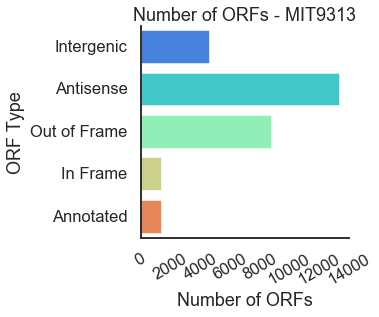

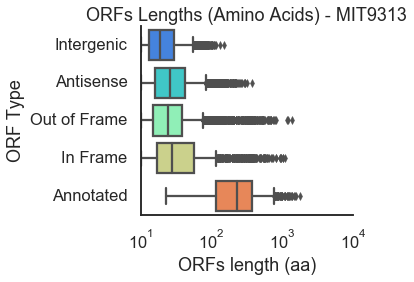

In [24]:
omap = {'standalone' : 'Intergenic', 
        'out_frame' : 'Out of Frame', 
        'antisense' : 'Antisense', 
        'in_frame' :'In Frame', 
        'known' : 'Annotated'}

genome = 'MIT9313'
df = pd.read_feather(os.path.join('orffinder_tmp', f'{genome}.ncbi.sorf.feather.gz'))
df = df.loc[df.otype != 'overlap']
df.otype = df.otype.map(omap)
    
sns.catplot(data=df, y='otype', kind='count', aspect=1.4, height=4,
       order=oorder, palette=opalette
           )
plt.xticks(rotation=30) 
plt.ylabel('ORF Type')
plt.xlabel('Number of ORFs')
plt.title(f'Number of ORFs - {genome}')

sns.catplot(data=df, y='otype', x='len_aa', aspect=1.4, height=4,
        kind='box',
       order=oorder, palette=opalette
           )
plt.xscale('log')
plt.ylabel('ORF Type')
plt.xlabel('ORFs length (aa)')

plt.title(f'ORFs Lengths (Amino Acids) - {genome}')
plt.show()
    

In [25]:
genome_df.head()

,contig_id,gene_id,pmt_id,type,location,strand,start,stop,left,right,...,genome,old_locus_tag,product,db_xref,protein_id,figfam,nucleotide_sequence,aa_sequence,family,Gene
0,MIT9313,AKG35_RS00005,PMT0001,CDS,AKG35_RS00005,+,173,1340,173,1340,...,MIT9313,"PMT0001,RG24_RS00005",DNA polymerase III subunit beta,GI:499441916,WP_011129380.1,,,MKLVCSQAELNTALQLVSRAVASRPTHPVLANVLLTADAGTDRLSL...,NaN,NaN
1,MIT9313,AKG35_RS00010,PMT0002,CDS,AKG35_RS00010,+,1343,2120,1343,2120,...,MIT9313,"PMT0002,RG24_RS00010",hypothetical protein,GI:752737102,WP_041384224.1,,,MNLPDQILLSDLLHHRVRCDQGLDHGPGVLPWMHPPVHRLLGWVSR...,NaN,NaN
2,MIT9313,AKG35_RS00015,PMT0003,CDS,AKG35_RS00015,+,2177,4562,2177,4562,...,MIT9313,"PMT0003,RG24_RS00015",phosphoribosylformylglycinamidine synthase sub...,GI:499441918,WP_011129382.1,,,MRVDYDVAAALRHEGLKPHDYDEICRRLQRAPNRVELGMFGVMWSE...,NaN,NaN
3,MIT9313,AKG35_RS00020,PMT0004,CDS,AKG35_RS00020,+,4621,6079,4621,6079,...,MIT9313,"PMT0004,RG24_RS00020",amidophosphoribosyltransferase,GI:499441919,WP_011129383.1,,,MCGIVGIVSTALVNQQIYDSLLLLQHRGQDSTGIATMDGSVFHLHK...,NaN,NaN
4,MIT9313,AKG35_RS00025,PMT0005,CDS,AKG35_RS00025,-,6114,8604,6114,8604,...,MIT9313,"PMT0005,RG24_RS00025",DNA topoisomerase 4 subunit A,GI:499441920,WP_011129384.1,,,MAEERLQPIALHQEMQRSYLEYAMSVIVGRALPDARDGLKPVQRRI...,NaN,NaN


In [26]:
df.loc[:,'merge_location'] = df['location']
df.loc[df['location'].isna(), 'merge_location'] = df.loc[df['location'].isna(), 'overlap_location']
df1 = pd.merge(df, genome_df, how='left', left_on='merge_location', right_on='location', suffixes=['', '_overlap'])

In [27]:
df1.loc[df1.otype == 'Annotated'].head().T

,27,34,40,57,70
orfid,ORF29_BX548175.1:12111:12746,ORF36_BX548175.1:15696:17108,ORF42_BX548175.1:18915:19421,ORF59_BX548175.1:26835:27080,ORF74_BX548175.1:34704:35198
contig,BX548175.1,BX548175.1,BX548175.1,BX548175.1,BX548175.1
left,12111,15696,18915,26835,34704
right,12746,17108,19421,27080,35198
start,12111,15696,18915,26835,34704
stop,12746,17108,19421,27080,35198
strand,+,+,+,+,+
aaseq,MQSRSLARELALLVLGQIPERESSRLKTISLESLLQKAFDTLSQHW...,MAGGVTSGSAEGWSKRFEEGLHPVIERFNASISFDITLLQEDLDGS...,MPITALLLSRRSLLIATIAGAFGVYRRPAAAFAATRAEDLDWSLSN...,MTAQLVPDQQIDLRGTPCPINFIRCRLALEGLKDKERLQVDLDRGE...,MAMQLDHDQLHQLLAALAESDIQEFRLEGDDFRLEVRRNIPAPAVV...
len_nn,636,1413,507,246,495
len_aa,211,470,168,81,164


In [28]:
protein_df = pd.read_excel(protein_fpath, skiprows=1)

In [29]:
protein_df['tempaccession'] = protein_df.Accession
protein_df.loc[~protein_df.tempaccession.isna(), 
               'tempaccession'] = protein_df.loc[~protein_df.Accession.isna(), 
                                             'Description']

In [30]:
protein_df.tempaccession = protein_df.tempaccession.fillna(method='ffill')

In [31]:
protein_df.head(20)

,Accession,Description,Score,Coverage,# Proteins,# Unique Peptides,# Peptides,# PSMs,Area,# AAs,MW [kDa],calc. pI,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,tempaccession
0,lcl,unnamed protein product - [ORF22701_BX548175.1...,264.49,74.73,1,9,9,66,7.47798e+10,91,9.82038,9.99365,NaN,NaN,NaN,NaN,NaN,NaN,unnamed protein product - [ORF22701_BX548175.1...
1,NaN,A4,Sequence,# PSMs,# Proteins,# Protein Groups,Protein Group Accessions,Modifications,ΔCn,Area,q-Value,PEP,XCorr,Charge,MH+ [Da],ΔM [ppm],RT [min],# Missed Cleavages,unnamed protein product - [ORF22701_BX548175.1...
2,NaN,High,TELTKTDVSLVVDAAIDTIIDSVVEGK,1,1,1,lcl,NaN,0,1.23224e+07,0,3.093e-16,8.84269,3,2831.51,-0.738287,232.912,1,unnamed protein product - [ORF22701_BX548175.1...
3,NaN,High,TDVSLVVDAAIDTIIDSVVEGK,5,1,1,lcl,NaN,0,4.81268e+07,0,5.897e-15,7.60091,3,2259.19,-2.39155,233.944,0,unnamed protein product - [ORF22701_BX548175.1...
4,NaN,High,TDVSLVVDAAIDTIIDSVVEGKK,2,1,1,lcl,NaN,0,6.16631e+07,0,5.524e-16,7.37785,3,2387.29,-2.2118,232.764,1,unnamed protein product - [ORF22701_BX548175.1...
5,NaN,High,MNKADLVNLVAAR,8,1,1,lcl,NaN,0,1.47952e+10,0,4.238e-11,4.74231,3,1414.78,-1.73153,133.758,1,unnamed protein product - [ORF22701_BX548175.1...
6,NaN,High,KVSILGFGSFEPR,14,1,1,lcl,NaN,0,4.30613e+10,0,1.339e-08,4.30086,3,1436.79,1.4483,159.75,1,unnamed protein product - [ORF22701_BX548175.1...
7,NaN,High,mNKADLVNLVAAR,17,1,1,lcl,M1(Oxidation),0,7.2085e+09,0,6.882e-12,4.17227,2,1430.77,-2.56394,118.3,1,unnamed protein product - [ORF22701_BX548175.1...
8,NaN,High,VSILGFGSFEPR,6,1,1,lcl,NaN,0,32742400928,0,2.905e-08,3.64569,2,1308.69,-1.94471,182.787,0,unnamed protein product - [ORF22701_BX548175.1...
9,NaN,High,RVPAFTAGK,5,1,1,lcl,NaN,0,109125673548,0,0.001684,3.59459,3,946.545,-1.8289,62.3578,1,unnamed protein product - [ORF22701_BX548175.1...


In [32]:
peptide_df = protein_df.loc[protein_df['Accession'].isna()]
peptide_df.drop(columns='Accession', inplace=True)
peptide_df2 = peptide_df.rename(columns=peptide_df.iloc[0])
peptide_df2['Description'] = peptide_df['tempaccession']
peptide_df = peptide_df2.loc[~peptide_df2.Sequence.isin(['Sequence'])]
peptide_df['orfid'] = peptide_df['Description'].str.replace(r'unnamed protein product - \[', '').str.replace('\]$','')


C:\Users\wosnat\Anaconda3\lib\site-packages\pandas\core\frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\wosnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [33]:
peptide_df.head()

,A4,Sequence,# PSMs,# Proteins,# Protein Groups,Protein Group Accessions,Modifications,ΔCn,Area,q-Value,PEP,XCorr,Charge,MH+ [Da],ΔM [ppm],RT [min],# Missed Cleavages,unnamed protein product - [ORF22701_BX548175.1:1481537:1481262],Description,orfid
2,High,TELTKTDVSLVVDAAIDTIIDSVVEGK,1,1,1,lcl,NaN,0,1.23224e+07,0,3.093e-16,8.84269,3,2831.51,-0.738287,232.912,1,unnamed protein product - [ORF22701_BX548175.1...,unnamed protein product - [ORF22701_BX548175.1...,ORF22701_BX548175.1:1481537:1481262
3,High,TDVSLVVDAAIDTIIDSVVEGK,5,1,1,lcl,NaN,0,4.81268e+07,0,5.897e-15,7.60091,3,2259.19,-2.39155,233.944,0,unnamed protein product - [ORF22701_BX548175.1...,unnamed protein product - [ORF22701_BX548175.1...,ORF22701_BX548175.1:1481537:1481262
4,High,TDVSLVVDAAIDTIIDSVVEGKK,2,1,1,lcl,NaN,0,6.16631e+07,0,5.524e-16,7.37785,3,2387.29,-2.2118,232.764,1,unnamed protein product - [ORF22701_BX548175.1...,unnamed protein product - [ORF22701_BX548175.1...,ORF22701_BX548175.1:1481537:1481262
5,High,MNKADLVNLVAAR,8,1,1,lcl,NaN,0,1.47952e+10,0,4.238e-11,4.74231,3,1414.78,-1.73153,133.758,1,unnamed protein product - [ORF22701_BX548175.1...,unnamed protein product - [ORF22701_BX548175.1...,ORF22701_BX548175.1:1481537:1481262
6,High,KVSILGFGSFEPR,14,1,1,lcl,NaN,0,4.30613e+10,0,1.339e-08,4.30086,3,1436.79,1.4483,159.75,1,unnamed protein product - [ORF22701_BX548175.1...,unnamed protein product - [ORF22701_BX548175.1...,ORF22701_BX548175.1:1481537:1481262


In [34]:
pdf = protein_df.dropna(subset=['Accession']).dropna(axis=1, how='all').reset_index(drop=True)

In [35]:
pdf.head()

,Accession,Description,Score,Coverage,# Proteins,# Unique Peptides,# Peptides,# PSMs,Area,# AAs,MW [kDa],calc. pI,tempaccession
0,lcl,unnamed protein product - [ORF22701_BX548175.1...,264.49,74.73,1,9,9,66,7.47798e+10,91,9.82038,9.99365,unnamed protein product - [ORF22701_BX548175.1...
1,lcl,unnamed protein product - [ORF27991_BX548175.1...,780.223,94.95,1,6,6,129,62668485687,99,10.6449,4.09424,unnamed protein product - [ORF27991_BX548175.1...
2,lcl,unnamed protein product - [ORF17148_BX548175.1...,438.661,72.82,1,9,9,100,6.19215e+10,103,10.8827,5.04639,unnamed protein product - [ORF17148_BX548175.1...
3,lcl,unnamed protein product - [ORF8286_BX548175.1:...,374.565,58.82,1,9,9,73,56217832856,170,18.1622,4.94482,unnamed protein product - [ORF8286_BX548175.1:...
4,lcl,unnamed protein product - [ORF17149_BX548175.1...,4179.86,90.99,1,59,61,851,5.5555e+10,544,57.3609,5.0083,unnamed protein product - [ORF17149_BX548175.1...


In [36]:
pdf['orfid'] = pdf['Description'].str.replace(r'unnamed protein product - \[', '').str.replace('\]$','')
pdf.head()

,Accession,Description,Score,Coverage,# Proteins,# Unique Peptides,# Peptides,# PSMs,Area,# AAs,MW [kDa],calc. pI,tempaccession,orfid
0,lcl,unnamed protein product - [ORF22701_BX548175.1...,264.49,74.73,1,9,9,66,7.47798e+10,91,9.82038,9.99365,unnamed protein product - [ORF22701_BX548175.1...,ORF22701_BX548175.1:1481537:1481262
1,lcl,unnamed protein product - [ORF27991_BX548175.1...,780.223,94.95,1,6,6,129,62668485687,99,10.6449,4.09424,unnamed protein product - [ORF27991_BX548175.1...,ORF27991_BX548175.1:1517947:1517648
2,lcl,unnamed protein product - [ORF17148_BX548175.1...,438.661,72.82,1,9,9,100,6.19215e+10,103,10.8827,5.04639,unnamed protein product - [ORF17148_BX548175.1...,ORF17148_BX548175.1:1537470:1537159
3,lcl,unnamed protein product - [ORF8286_BX548175.1:...,374.565,58.82,1,9,9,73,56217832856,170,18.1622,4.94482,unnamed protein product - [ORF8286_BX548175.1:...,ORF8286_BX548175.1:1515352:1515864
4,lcl,unnamed protein product - [ORF17149_BX548175.1...,4179.86,90.99,1,59,61,851,5.5555e+10,544,57.3609,5.0083,unnamed protein product - [ORF17149_BX548175.1...,ORF17149_BX548175.1:1537077:1535443


In [37]:
merge_df = pd.merge(df1, pdf, how='left', on='orfid', suffixes=['','_p'])

In [38]:
merge_df.rename(columns={
    '# Proteins': 'Proteins', 
    '# Unique Peptides':'Unique Peptides', 
    '# Peptides' : 'Peptides', 
    '# PSMs': 'PSMs',
    '# AAs' : 'AAs'
}, inplace=True)

In [39]:
peptide_df.rename(columns={
    '# Proteins': 'Proteins', 
}, inplace=True)

C:\Users\wosnat\Anaconda3\lib\site-packages\pandas\core\frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [40]:
peptide_df.loc[peptide_df.Proteins == 1].groupby('orfid')['XCorr'].max()

orfid
ORF10018_BX548175.1:2374408:2375442    5.388735
ORF10058_BX548175.1:2390491:2391408    7.522972
ORF10064_BX548175.1:2394349:2394654    8.271802
ORF10086_BX548175.1:173:1339           7.894603
ORF10087_BX548175.1:1439:2119          4.605703
                                         ...   
ORF9945_BX548175.1:2340268:2341182     5.265483
ORF9959_BX548175.1:2349358:2350047     2.773762
ORF9995_BX548175.1:2364358:2364552     2.701195
ORF9999_BX548175.1:2365138:2366766     5.896854
ORF99_BX548175.1:44826:46412           7.255951
Name: XCorr, Length: 1623, dtype: float64

In [41]:
merge_df['max_xCorr'] = merge_df['orfid'].map(peptide_df.loc[peptide_df.Proteins == 1].groupby('orfid')['XCorr'].max())

In [42]:
(~merge_df.isna()).sum()

orfid            34503
contig           34503
left             34503
right            34503
start            34503
                 ...  
AAs               1464
MW [kDa]          1464
calc. pI          1464
tempaccession     1464
max_xCorr         1461
Length: 73, dtype: int64

In [43]:
merge_df['multiple unique peptides'] = merge_df['Unique Peptides'] > 1
merge_df['has unique peptides'] = merge_df['Unique Peptides'] > 0
merge_df['ms_detected'] = (merge_df['Unique Peptides'] > 1) | (merge_df['max_xCorr'] > 3)

In [104]:
merge_df.shape

(34503, 76)

In [105]:
genome_df.type.value_counts()

CDS           2386
tRNA            44
rRNA             6
ncRNA            3
regulatory       2
tmRNA            1
Name: type, dtype: int64

In [103]:
merge_df['otype'].value_counts()

Antisense       13413
Intergenic       9334
Out of Frame     8841
Annotated        1472
In Frame         1443
Name: otype, dtype: int64

In [44]:
merge_df['ms_detected'].value_counts()

False    33145
True      1358
Name: ms_detected, dtype: int64

C:\Users\wosnat\Anaconda3\lib\site-packages\seaborn\categorical.py:1324: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\Users\wosnat\Anaconda3\lib\site-packages\seaborn\categorical.py:1328: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


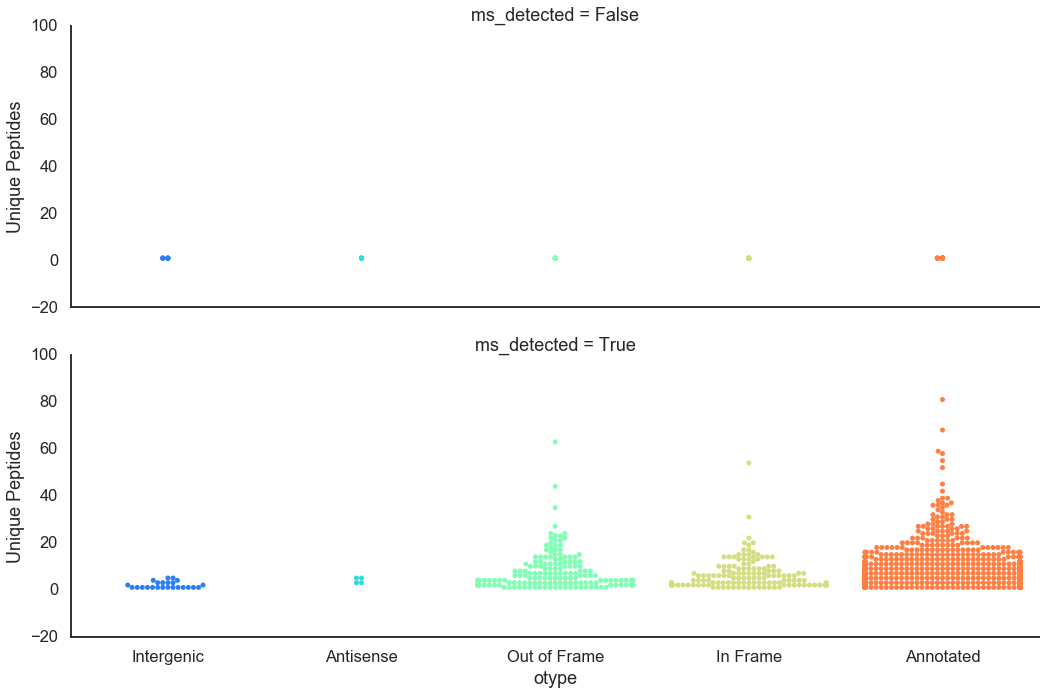

In [45]:
sns.catplot(data=merge_df, x='otype', y='Unique Peptides', aspect=3, kind='swarm', order=oorder, palette=opalette
           , row='ms_detected')

Text(0.5,1,'multiple unique peptides')

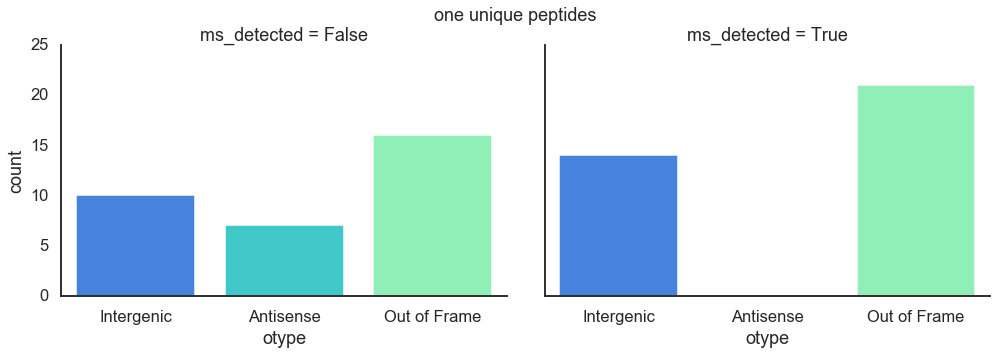

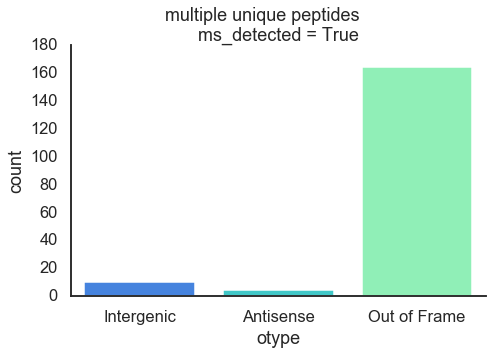

In [46]:
sns.catplot(data=merge_df.loc[(merge_df['Unique Peptides'] == 1) & ~merge_df.otype.isin(['Annotated', 'In Frame'])], 
            order=oorder[0:3], palette=opalette[0:3],
            x='otype', kind='count',  aspect=1.4, col='ms_detected')
plt.suptitle('one unique peptides', y=1)
sns.catplot(data=merge_df.loc[merge_df['multiple unique peptides'] & ~merge_df.otype.isin(['Annotated', 'In Frame'])], 
            order=oorder[0:3], palette=opalette[0:3],
            x='otype', kind='count',  aspect=1.4, col='ms_detected')
plt.suptitle('multiple unique peptides', y=1)


In [47]:
merge_df['Unique Peptides'] = pd.to_numeric(merge_df['Unique Peptides'])
merge_df['Coverage'] = pd.to_numeric(merge_df['Coverage'])


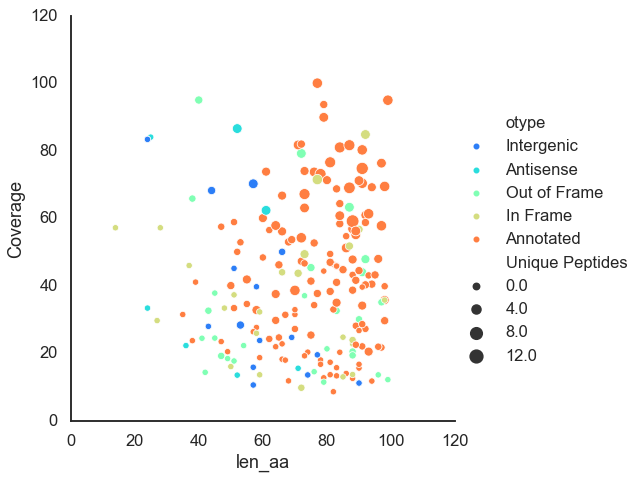

In [48]:
sns.relplot(data=merge_df.loc[merge_df['has unique peptides'] #& ~merge_df.otype.isin(['Annotated', 'In Frame'])
                             & (merge_df.len_aa < 100)], 
            hue_order=oorder, palette=opalette,
            size='Unique Peptides',
            hue='otype', y='Coverage', x='len_aa', s=50,
            height=7,
           )


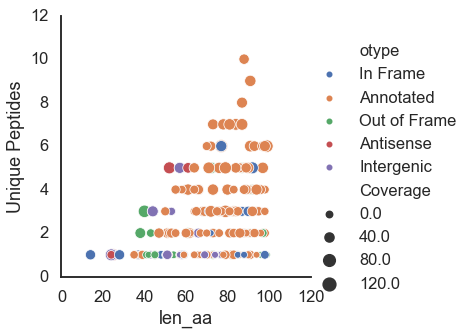

In [49]:
sns.relplot(data=merge_df.loc[merge_df['has unique peptides'] #& ~merge_df.otype.isin(['Annotated', 'In Frame'])
                             & (merge_df.len_aa < 100)], 
            #hue_order=oorder, palette=opalette,
            y='Unique Peptides',
            hue='otype', size='Coverage', x='len_aa', #s=50
           )


In [50]:
merge_df.loc[merge_df['has unique peptides'] & ~merge_df.otype.isin(['Annotated', 'In Frame'])]['Unique Peptides'].value_counts()

1.0     68
2.0     36
4.0     26
3.0     24
5.0     14
7.0     10
10.0     7
6.0      7
14.0     7
12.0     6
8.0      6
11.0     5
9.0      4
15.0     3
19.0     3
17.0     3
21.0     2
24.0     2
23.0     2
13.0     2
22.0     2
20.0     1
35.0     1
27.0     1
16.0     1
18.0     1
63.0     1
44.0     1
Name: Unique Peptides, dtype: int64

In [51]:
merge_df.columns

Index(['orfid', 'contig', 'left', 'right', 'start', 'stop', 'strand', 'aaseq',
       'len_nn', 'len_aa', 'len_aa3', 'rast_left', 'rast_right', 'contig_id',
       'gene_id', 'location', 'type', 'start_r', 'stop_r', 'function',
       'figfam', 'nucleotide_sequence', 'aa_sequence', 'genome', 'left_r',
       'right_r', 'overlap_location', 'overlap_strand', 'overlap_gene_type',
       'overlap_count', 'is_same_strand', 'is_out_of_frame', 'is_inside',
       'is_upstream', 'is_downstream', 'overlap_type', 'otype',
       'merge_location', 'contig_id_overlap', 'gene_id_overlap', 'pmt_id',
       'type_overlap', 'location_overlap', 'strand_overlap', 'start_overlap',
       'stop_overlap', 'left_overlap', 'right_overlap', 'function_overlap',
       'genome_overlap', 'old_locus_tag', 'product', 'db_xref', 'protein_id',
       'figfam_overlap', 'nucleotide_sequence_overlap', 'aa_sequence_overlap',
       'family', 'Gene', 'Accession', 'Description', 'Score', 'Coverage',
       'Proteins', 'Un

(0, 2600000)

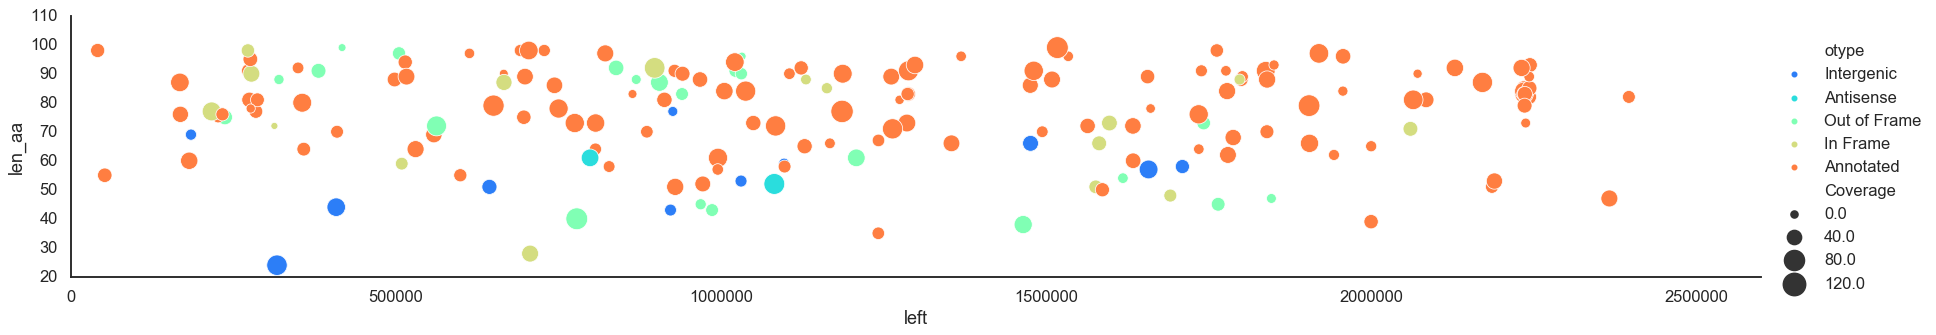

In [52]:
sns.relplot(data=merge_df.loc[merge_df['ms_detected'] # & ~merge_df.otype.isin(['In Frame'])
                             & (merge_df.len_aa < 100)], 
            hue_order=oorder, palette=opalette,
            #style='Unique Peptides',
            hue='otype', size='Coverage', y='len_aa', 
            x='left',
            sizes=(50,500),
            aspect=5,
            #markers=range(10)
           )
plt.xlim(0,2600000)

(0, 2600000)

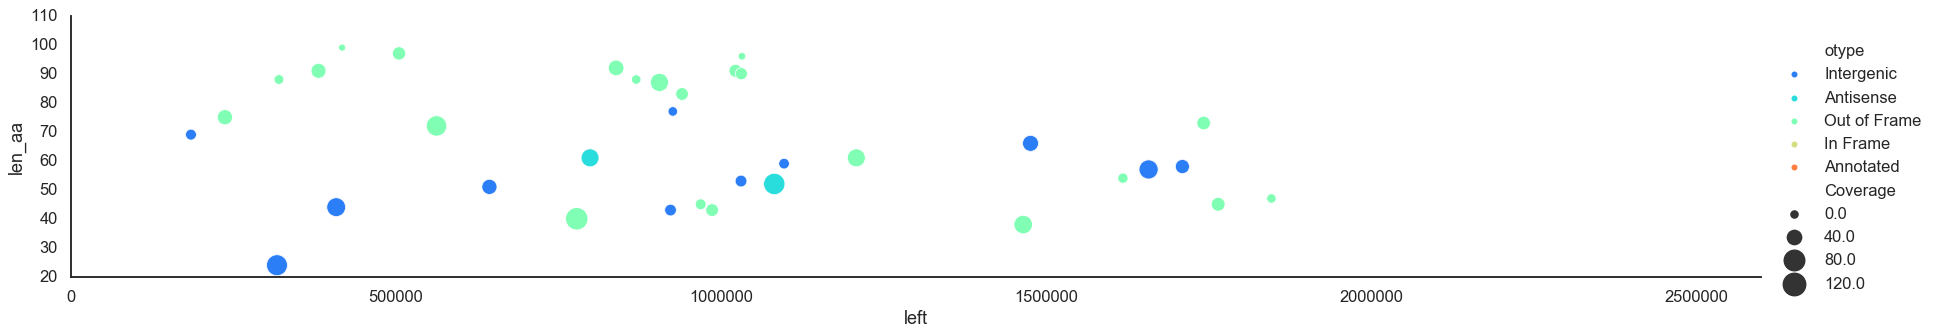

In [53]:
sns.relplot(data=merge_df.loc[merge_df['ms_detected'] & ~merge_df.otype.isin(['Annotated', 'In Frame'])
                             & (merge_df.len_aa < 100)], 
            hue_order=oorder, palette=opalette,
            #y='Unique Peptides',
            hue='otype', size='Coverage', y='len_aa', 
            x='left',
            sizes=(50,500),
            aspect=5,
            
           )
plt.xlim(0,2600000)

(0, 2500000)

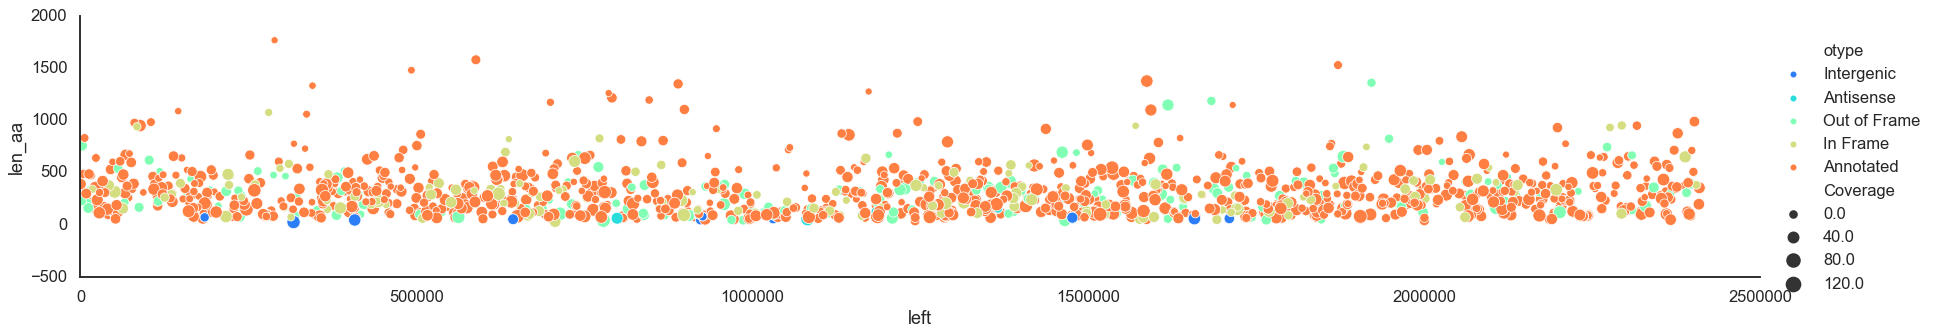

In [54]:
sns.relplot(data=merge_df.loc[merge_df['ms_detected'] #& ~merge_df.otype.isin(['In Frame'])
                         #    & (merge_df.len_aa < 100)
                             ], 
            hue_order=oorder, palette=opalette,
            #y='Unique Peptides',
            hue='otype', size='Coverage', y='len_aa', 
            x='left',
            sizes=(50,200),
            aspect=5,
            
           )
plt.xlim(0,2500000)

In [55]:
merge_df.otype.unique()

array(['Out of Frame', 'Antisense', 'Annotated', 'In Frame', 'Intergenic'],
      dtype=object)

Text(0.5,1,'protein found < 100 aa')

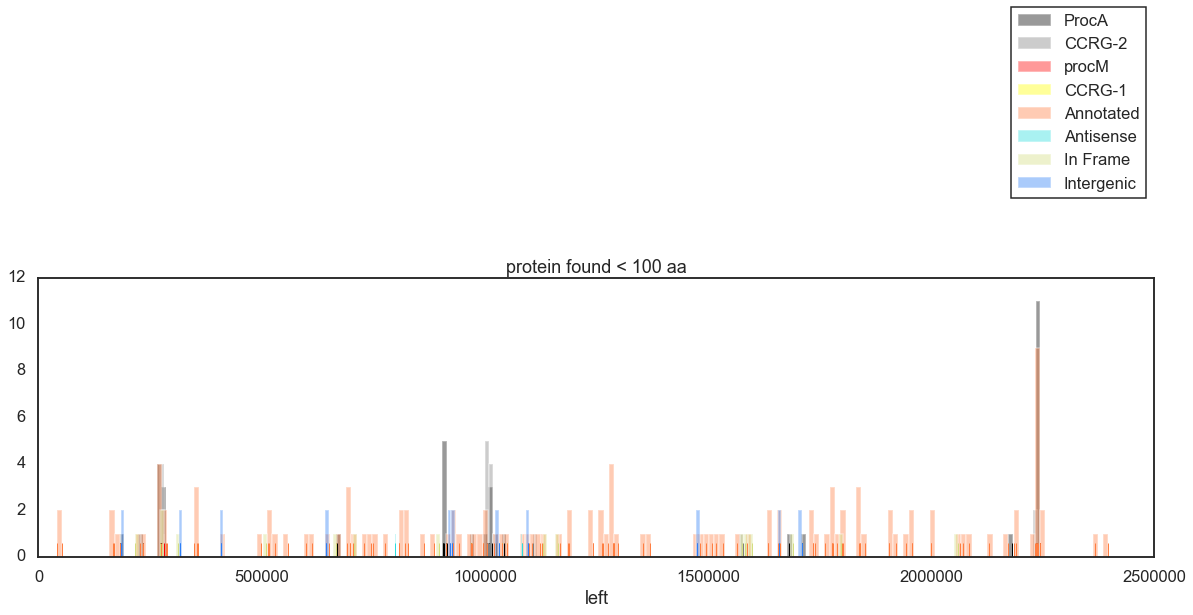

In [56]:
fig, ax = plt.subplots(figsize=(20,5))
for i,j in zip(['ProcA', 'CCRG-2', 'procM', 'CCRG-1'], ['black', 'grey', 'red', 'yellow']):
    sns.distplot(genome_df.loc[genome_df['family'].isin([i]),
                               'left'
                             ], 
             color=j,
                 bins=200,
             label=i, rug=True, kde=False, ax=ax
           )
for i in [ 'Annotated', 'Antisense', 
          'In Frame', #'Out of Frame',
          'Intergenic']:
    sns.distplot(merge_df.loc[merge_df['ms_detected'] & merge_df.otype.isin([i])
                         & (merge_df.len_aa < 100), 'left'
                             ], 
             color=opalette[oorder.index(i)],
                 bins=200,
             label=i, rug=True, kde=False, ax=ax
           )
    
plt.xlim(0,2500000)
plt.legend(bbox_to_anchor=(1,2))
plt.title('protein found < 100 aa')

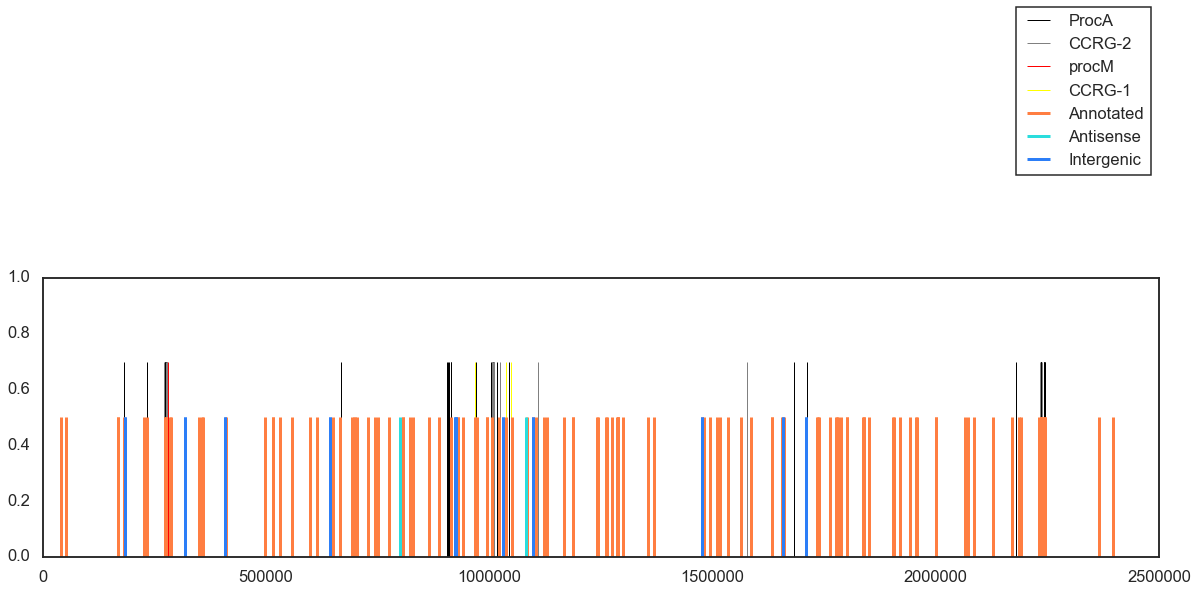

In [125]:
fig, ax = plt.subplots(figsize=(20,5))
for i,j in zip(['ProcA', 'CCRG-2', 'procM', 'CCRG-1'], ['black', 'grey', 'red', 'yellow']):
    sns.rugplot(genome_df.loc[genome_df['family'].isin([i]),
                               'left'
                             ], 
             color=j,
           #      bins=200,
             label=i, #rug=True, kde=False, 
                height=0.7,
                linewidths=2,
                ax=ax
                
           )
for i in [ 'Annotated', 'Antisense', 
          #'In Frame', 'Out of Frame',
          'Intergenic']:
    sns.rugplot(merge_df.loc[merge_df['ms_detected'] & merge_df.otype.isin([i])
                         & (merge_df.len_aa < 100), 'left'
                             ], 
             color=opalette[oorder.index(i)],
           #      bins=2000,
                height=0.5,
                linewidth=3,
                
             label=i, #rug=True, kde=False, 
                ax=ax
           )
    
#plt.xlim(800000,1100000)
plt.legend(bbox_to_anchor=(1,2))
#plt.title('protein found < 100 aa')

(800000, 1100000)

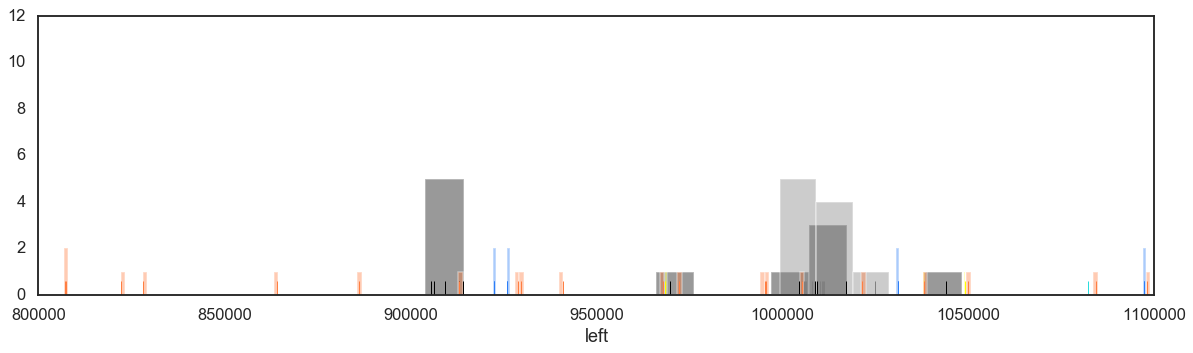

In [57]:
fig, ax = plt.subplots(figsize=(20,5))
for i,j in zip(['ProcA', 'CCRG-2', 'procM', 'CCRG-1'], ['black', 'grey', 'red', 'yellow']):
    sns.barplot(genome_df.loc[genome_df['family'].isin([i]),
                               'left'
                             ], 
             color=j,
                 bins=200,
             label=i, rug=True, kde=False, ax=ax
           )
for i in [ 'Annotated', 'Antisense', 
          #'In Frame', 'Out of Frame',
          'Intergenic']:
    sns.barplot(merge_df.loc[merge_df['ms_detected'] & merge_df.otype.isin([i])
                         & (merge_df.len_aa < 100), 'left'
                             ], 
             color=opalette[oorder.index(i)],
                 bins=2000,
             label=i, rug=True, kde=False, ax=ax
           )
    
plt.xlim(800000,1100000)
#plt.legend(bbox_to_anchor=(1,2))
#plt.title('protein found < 100 aa')

(200000, 500000)

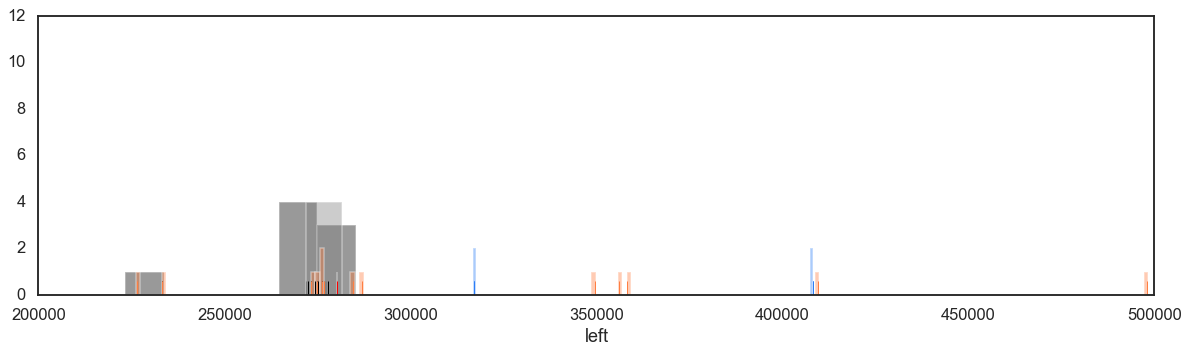

In [58]:
fig, ax = plt.subplots(figsize=(20,5))
for i,j in zip(['ProcA', 'CCRG-2', 'procM', 'CCRG-1'], ['black', 'grey', 'red', 'yellow']):
    sns.distplot(genome_df.loc[genome_df['family'].isin([i]),
                               'left'
                             ], 
             color=j,
                 bins=200,
             label=i, rug=True, kde=False, ax=ax
           )
for i in [ 'Annotated', 'Antisense', 
          #'In Frame', 'Out of Frame',
          'Intergenic']:
    sns.distplot(merge_df.loc[merge_df['ms_detected'] & merge_df.otype.isin([i])
                         & (merge_df.len_aa < 100), 'left'
                             ], 
             color=opalette[oorder.index(i)],
                 bins=2000,
             label=i, rug=True, kde=False, ax=ax
           )
    
plt.xlim(200000,500000)
#plt.legend(bbox_to_anchor=(1,2))
#plt.title('protein found < 100 aa')

(2100000, 2300000)

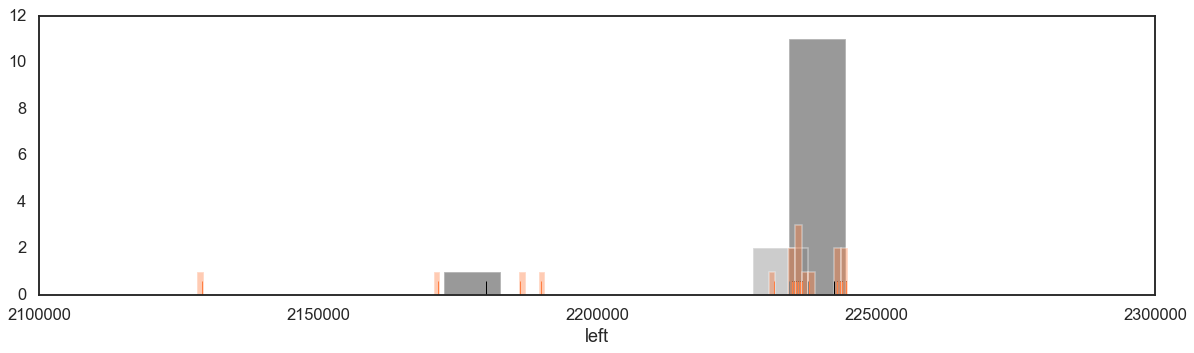

In [59]:
fig, ax = plt.subplots(figsize=(20,5))
for i,j in zip(['ProcA', 'CCRG-2', 'procM', 'CCRG-1'], ['black', 'grey', 'red', 'yellow']):
    sns.distplot(genome_df.loc[genome_df['family'].isin([i]),
                               'left'
                             ], 
             color=j,
                 bins=200,
             label=i, rug=True, kde=False, ax=ax
           )
for i in [ 'Annotated', 'Antisense', 
          #'In Frame', 'Out of Frame',
          'Intergenic']:
    sns.distplot(merge_df.loc[merge_df['ms_detected'] & merge_df.otype.isin([i])
                         & (merge_df.len_aa < 100), 'left'
                             ], 
             color=opalette[oorder.index(i)],
                 bins=2000,
             label=i, rug=True, kde=False, ax=ax
           )
    
plt.xlim(2100000,2300000)
#plt.legend(bbox_to_anchor=(1,2))
#plt.title('protein found < 100 aa')

In [60]:
genome_df['family'].unique()

array([nan, 'ProcA', 'CCRG-2', 'procM', 'CCRG-1', 'ABC transporter'],
      dtype=object)

(0, 2500000)

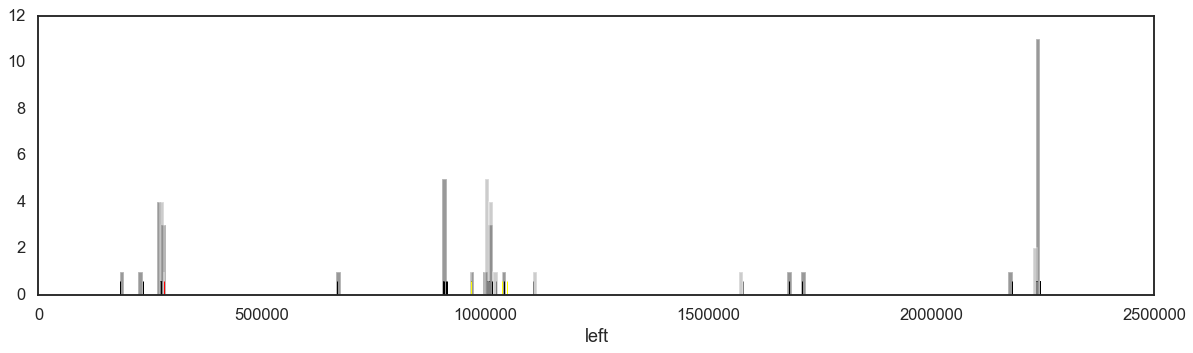

In [61]:
fig, ax = plt.subplots(figsize=(20,5))
for i,j in zip(['ProcA', 'CCRG-2', 'procM', 'CCRG-1'], ['black', 'grey', 'red', 'yellow']):
    sns.distplot(genome_df.loc[genome_df['family'].isin([i]),
                         #& (merge_df.len_aa < 100), 
                               'left'
                             ], 
             color=j,
                 bins=200,
             label=i, rug=True, kde=False, ax=ax
           )
plt.xlim(0,2500000)
#plt.legend()

In [62]:
genome_df.head()

,contig_id,gene_id,pmt_id,type,location,strand,start,stop,left,right,...,genome,old_locus_tag,product,db_xref,protein_id,figfam,nucleotide_sequence,aa_sequence,family,Gene
0,MIT9313,AKG35_RS00005,PMT0001,CDS,AKG35_RS00005,+,173,1340,173,1340,...,MIT9313,"PMT0001,RG24_RS00005",DNA polymerase III subunit beta,GI:499441916,WP_011129380.1,,,MKLVCSQAELNTALQLVSRAVASRPTHPVLANVLLTADAGTDRLSL...,NaN,NaN
1,MIT9313,AKG35_RS00010,PMT0002,CDS,AKG35_RS00010,+,1343,2120,1343,2120,...,MIT9313,"PMT0002,RG24_RS00010",hypothetical protein,GI:752737102,WP_041384224.1,,,MNLPDQILLSDLLHHRVRCDQGLDHGPGVLPWMHPPVHRLLGWVSR...,NaN,NaN
2,MIT9313,AKG35_RS00015,PMT0003,CDS,AKG35_RS00015,+,2177,4562,2177,4562,...,MIT9313,"PMT0003,RG24_RS00015",phosphoribosylformylglycinamidine synthase sub...,GI:499441918,WP_011129382.1,,,MRVDYDVAAALRHEGLKPHDYDEICRRLQRAPNRVELGMFGVMWSE...,NaN,NaN
3,MIT9313,AKG35_RS00020,PMT0004,CDS,AKG35_RS00020,+,4621,6079,4621,6079,...,MIT9313,"PMT0004,RG24_RS00020",amidophosphoribosyltransferase,GI:499441919,WP_011129383.1,,,MCGIVGIVSTALVNQQIYDSLLLLQHRGQDSTGIATMDGSVFHLHK...,NaN,NaN
4,MIT9313,AKG35_RS00025,PMT0005,CDS,AKG35_RS00025,-,6114,8604,6114,8604,...,MIT9313,"PMT0005,RG24_RS00025",DNA topoisomerase 4 subunit A,GI:499441920,WP_011129384.1,,,MAEERLQPIALHQEMQRSYLEYAMSVIVGRALPDARDGLKPVQRRI...,NaN,NaN


In [63]:
merge_df.loc[merge_df['ms_detected'] #& merge_df.otype.isin([i])
                         & (merge_df.len_aa < 100), 'otype'].value_counts()


Annotated       127
Out of Frame     22
Intergenic       22
In Frame         16
Antisense         2
Name: otype, dtype: int64

In [64]:
merge_df.loc[merge_df['ms_detected'] #& merge_df.otype.isin([i])
                         & (merge_df.len_aa < 100)].groupby(['otype', 'family'])['Unique Peptides'].count()
             #,'family'].value_counts()


otype         family
Annotated     CCRG-1     1
              CCRG-2     2
              ProcA     16
In Frame      ProcA      2
Out of Frame  ProcA      1
Name: Unique Peptides, dtype: int64

In [65]:
found_sorf_df = merge_df.loc[merge_df['ms_detected'] & ~merge_df.otype.isin(['Out Frame'])
                             & (merge_df.len_aa < 100)
                             & (
                                 ~merge_df.otype.isin(['In Frame']) 
                                 | (merge_df.aa_sequence_overlap.str.len() < 100)
                             )
                            ]

In [66]:
found_sorf_df.shape

(180, 76)

In [67]:
found_sorf_df.to_pickle('found_sorf_ISME16.pkl.gz')

In [68]:
def is_in_found_sorf(r):
    orfid = r.id.replace('lcl|','')
    return found_sorf_df.orfid.isin([orfid]).sum() > 0
    

In [69]:
accession = sf.get_accession(genome)
orf_dpath = 'orffinder_tmp'
orf_fpath = os.path.join(orf_dpath, f'{accession}.orffinder.fa')

In [70]:
from Bio import SeqIO
records = (r for r in SeqIO.parse(orf_fpath, "fasta") if is_in_found_sorf(r))

In [71]:
out_fpath = os.path.join(orf_dpath, f'{genome}_found_proteome.fasta')
count = SeqIO.write(records, out_fpath, "fasta")
print("Saved %i records from %s to %s" % (count, orf_fpath, out_fpath))

Saved 169 records from orffinder_tmp\BX548175.orffinder.fa to orffinder_tmp\MIT9313_found_proteome.fasta


 mit9313_found_vs_pro_syn    https://blast.ncbi.nlm.nih.gov/Blast.cgi?CMD=Get&RID=8P2ACMPV014    
 mit9313_found_vs_nr         https://blast.ncbi.nlm.nih.gov/Blast.cgi?CMD=Get&RID=8P26YCM7014
 mit9313_found_vs_swisprot   https://blast.ncbi.nlm.nih.gov/Blast.cgi?CMD=Get&RID=8SHSH1FU014
 

In [72]:
blast_dpath = os.path.join('orffinder_tmp','blast results')
blast_vs_nr_dpath = os.path.join(blast_dpath, 'mit9313_found_vs_nr-Alignment.xml')
blast_vs_pro_dpath = os.path.join(blast_dpath, 'mit9313_found_vs_pro_syn-Alignment.xml')
blast_vs_sorf_dpath = os.path.join(blast_dpath, 'mit9313_sorf_all_vs_all.xml')
blast_vs_swisprot_dpath = os.path.join(blast_dpath, 'mit9313_found_vs_swisprot-Alignment.xml')

os.listdir(blast_dpath)

['mit9313_blastn_vs_pro_syn-Alignment.xml',
 'MIT9313_found_proteome.fasta',
 'mit9313_found_vs_nr-Alignment.xml',
 'mit9313_found_vs_pro_syn-Alignment.xml',
 'mit9313_found_vs_swisprot-Alignment.xml',
 'mit9313_sorf_all_vs_all.xml']

In [73]:
from Bio.Blast import NCBIXML


In [74]:
def blast_rec_to_dict(blast_rec):
    query_id = blast_rec.query.replace(' unnamed protein product','').replace('lcl|','')
    results = [{
        'query' : query_id,
        'aligment_id' : alignment.hit_id,
        'alignment_def' : alignment.hit_def,
        
        }
        for alignment in blast_rec.alignments if alignment.hit_id != query_id
    ]
    return results

In [75]:
fh = open(blast_vs_sorf_dpath)
blast_records = NCBIXML.parse(fh)
reslist = [blast_rec_to_dict(b) for b in blast_records]
blast_vs_sorf_df = pd.DataFrame([i for lst in reslist for i in lst])

In [76]:
fh.close()

In [77]:
for query in blast_records:
    for alignment in query.alignments:
        for hsp in alignment.hsps:
            print('coverage', hsp.align_length / query.query_length)
            print('identitiy', hsp.identities/ hsp.align_length)

In [78]:

blast_vs_sorf_df['query'].value_counts()

ORF25368_BX548175.1:272714:272418      18
ORF25455_BX548175.1:233492:233262      18
ORF15637_BX548175.1:2235903:2235652    18
ORF20045_BX548175.1:274995:274750      18
ORF2049_BX548175.1:913137:913382       18
ORF7032_BX548175.1:905452:905715       18
ORF26353_BX548175.1:2243725:2243456    18
ORF20960_BX548175.1:2244944:2244663    18
ORF20053_BX548175.1:273630:273355      18
ORF26352_BX548175.1:2244112:2243855    18
ORF15638_BX548175.1:2235486:2235229    18
ORF26370_BX548175.1:2237020:2236769    18
ORF20982_BX548175.1:2236277:2236026    18
ORF15639_BX548175.1:2235150:2234896    18
ORF5422_BX548175.1:182116:182298       18
ORF15620_BX548175.1:2243295:2243047    18
ORF25353_BX548175.1:276446:276159      18
ORF25351_BX548175.1:278051:277779      18
ORF26372_BX548175.1:2236618:2236379    18
ORF23202_BX548175.1:1242650:1242447     4
ORF12488_BX548175.1:1070888:1071013     4
ORF7400_BX548175.1:1069051:1069200      3
ORF15630_BX548175.1:2238480:2238277     3
ORF30798_BX548175.1:276922:276686 

In [79]:
blast_vs_sorf_df.head()

,query,aligment_id,alignment_def
0,ORF2049_BX548175.1:913137:913382,ORF26372_BX548175.1:2236618:2236379,unnamed protein product
1,ORF2049_BX548175.1:913137:913382,ORF26370_BX548175.1:2237020:2236769,unnamed protein product
2,ORF2049_BX548175.1:913137:913382,ORF20045_BX548175.1:274995:274750,unnamed protein product
3,ORF2049_BX548175.1:913137:913382,ORF20982_BX548175.1:2236277:2236026,unnamed protein product
4,ORF2049_BX548175.1:913137:913382,ORF15639_BX548175.1:2235150:2234896,unnamed protein product


In [80]:
def create_sorfs_cluster(blast_vs_sorf_df, cluster_sorfs):
    new_alignments = set(
        blast_vs_sorf_df.loc[blast_vs_sorf_df['query'].isin(cluster_sorfs), 'aligment_id'].unique()
    )
    new_queries = set(
        blast_vs_sorf_df.loc[blast_vs_sorf_df['aligment_id'].isin(cluster_sorfs), 'query'].unique()
    )
    if (new_alignments <= cluster_sorfs) and (new_queries <= cluster_sorfs):
        return cluster_sorfs
    else:
        new_cluster_sorfs = cluster_sorfs | new_alignments | new_queries
        return create_sorfs_cluster(blast_vs_sorf_df, new_cluster_sorfs)
    
    

In [81]:
def create_sorfs_cluster_sel_root(blast_vs_sorf_df, visited):
    not_visited = blast_vs_sorf_df.loc[~blast_vs_sorf_df['query'].isin(visited), 'query'].unique()
    if len(not_visited):
        return create_sorfs_cluster(blast_vs_sorf_df, {not_visited[0]})
    #else
    not_visited2 = blast_vs_sorf_df.loc[~blast_vs_sorf_df['aligment_id'].isin(visited), 'aligment_id'].unique()
    if len(not_visited2):
        return create_sorfs_cluster(blast_vs_sorf_df, {not_visited2[0]})
    # else
    return None
    


In [82]:
visited = set()
clusters = []
while(True):
    new_cluster = create_sorfs_cluster_sel_root(blast_vs_sorf_df, visited)
    if new_cluster is None:
        break
    visited = visited | new_cluster
    clusters.append(new_cluster)
    

In [83]:
len(clusters)

10

In [84]:
found_sorf_df.head()

,orfid,contig,left,right,start,stop,strand,aaseq,len_nn,len_aa,...,PSMs,Area,AAs,MW [kDa],calc. pI,tempaccession,max_xCorr,multiple unique peptides,has unique peptides,ms_detected
578,ORF533_BX548175.1:237054:237281,BX548175.1,237054,237281,237054,237281,+,MLYLVAPAGDGRDVYATLYAQRMFFLVTLQPRGAQFEVIPYQDARH...,228,75,...,4,3.04707e+08,75,8.89242,6.771,unnamed protein product - [ORF533_BX548175.1:2...,4.305928,True,True,True
2285,ORF2049_BX548175.1:913137:913382,BX548175.1,913137,913382,913137,913382,+,MSEEQLKAFIAKVQGDTSLQEQLKAEGADVVAIAKAAGFSITTEDL...,246,81,...,12,7.4183e+09,81,8.50516,4.48779,unnamed protein product - [ORF2049_BX548175.1:...,5.280437,True,True,True
2316,ORF2068_BX548175.1:922530:922661,BX548175.1,922530,922661,922530,922661,+,MMGKTKQHKKLVSWAEKAELCATREEAQKLIRKAEKAHAKLES,132,43,...,1,64315285,43,4.93366,9.71533,unnamed protein product - [ORF2068_BX548175.1:...,3.770810,False,True,True
2317,ORF2068_BX548175.1:922530:922661,BX548175.1,922530,922661,922530,922661,+,MMGKTKQHKKLVSWAEKAELCATREEAQKLIRKAEKAHAKLES,132,43,...,1,64315285,43,4.93366,9.71533,unnamed protein product - [ORF2068_BX548175.1:...,3.770810,False,True,True
2380,ORF2106_BX548175.1:940263:940514,BX548175.1,940263,940514,940263,940514,+,MGFLHELEISDGGHRFELASHDHPDHHHLVCVRCGRTEEFESKPVL...,252,83,...,6,3.38278e+08,83,9.29551,6.50732,unnamed protein product - [ORF2106_BX548175.1:...,3.996620,True,True,True


In [85]:
for i,c in enumerate(clusters, start=1):
    found_sorf_df.loc[found_sorf_df.orfid.isin(c), 'cluster_id'] = i

C:\Users\wosnat\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\wosnat\Anaconda3\lib\site-packages\pandas\core\indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [86]:
found_sorf_df.head()

,orfid,contig,left,right,start,stop,strand,aaseq,len_nn,len_aa,...,Area,AAs,MW [kDa],calc. pI,tempaccession,max_xCorr,multiple unique peptides,has unique peptides,ms_detected,cluster_id
578,ORF533_BX548175.1:237054:237281,BX548175.1,237054,237281,237054,237281,+,MLYLVAPAGDGRDVYATLYAQRMFFLVTLQPRGAQFEVIPYQDARH...,228,75,...,3.04707e+08,75,8.89242,6.771,unnamed protein product - [ORF533_BX548175.1:2...,4.305928,True,True,True,NaN
2285,ORF2049_BX548175.1:913137:913382,BX548175.1,913137,913382,913137,913382,+,MSEEQLKAFIAKVQGDTSLQEQLKAEGADVVAIAKAAGFSITTEDL...,246,81,...,7.4183e+09,81,8.50516,4.48779,unnamed protein product - [ORF2049_BX548175.1:...,5.280437,True,True,True,1.0
2316,ORF2068_BX548175.1:922530:922661,BX548175.1,922530,922661,922530,922661,+,MMGKTKQHKKLVSWAEKAELCATREEAQKLIRKAEKAHAKLES,132,43,...,64315285,43,4.93366,9.71533,unnamed protein product - [ORF2068_BX548175.1:...,3.770810,False,True,True,NaN
2317,ORF2068_BX548175.1:922530:922661,BX548175.1,922530,922661,922530,922661,+,MMGKTKQHKKLVSWAEKAELCATREEAQKLIRKAEKAHAKLES,132,43,...,64315285,43,4.93366,9.71533,unnamed protein product - [ORF2068_BX548175.1:...,3.770810,False,True,True,NaN
2380,ORF2106_BX548175.1:940263:940514,BX548175.1,940263,940514,940263,940514,+,MGFLHELEISDGGHRFELASHDHPDHHHLVCVRCGRTEEFESKPVL...,252,83,...,3.38278e+08,83,9.29551,6.50732,unnamed protein product - [ORF2106_BX548175.1:...,3.996620,True,True,True,NaN


In [87]:
found_sorf_df.groupby(['cluster_id', 'otype', 'orfid', 'product', #'family'
                      ])['family'].unique().str.join(',').reset_index()

,cluster_id,otype,orfid,product,family
0,1.0,Annotated,ORF15620_BX548175.1:2243295:2243047,Nif11-like leader peptide family natural produ...,ProcA
1,1.0,Annotated,ORF15637_BX548175.1:2235903:2235652,Nif11-like leader peptide family natural produ...,ProcA
2,1.0,Annotated,ORF15638_BX548175.1:2235486:2235229,lantipeptide,ProcA
3,1.0,Annotated,ORF15639_BX548175.1:2235150:2234896,Nif11-like leader peptide family natural produ...,ProcA
4,1.0,Annotated,ORF20045_BX548175.1:274995:274750,Nif11-like leader peptide family natural produ...,ProcA
5,1.0,Annotated,ORF20053_BX548175.1:273630:273355,Nif11-like leader peptide family natural produ...,ProcA
6,1.0,Annotated,ORF2049_BX548175.1:913137:913382,Nif11-like leader peptide family natural produ...,ProcA
7,1.0,Annotated,ORF20960_BX548175.1:2244944:2244663,Nif11-like leader peptide family natural produ...,ProcA
8,1.0,Annotated,ORF20982_BX548175.1:2236277:2236026,Nif11-like leader peptide family natural produ...,ProcA
9,1.0,Annotated,ORF25353_BX548175.1:276446:276159,Nif11-like leader peptide family natural produ...,ProcA


In [88]:
found_sorf_df.groupby(['cluster_id', 'otype', 'orfid', #'product'
                      ])['Unique Peptides'].count().reset_index().otype.value_counts()

Annotated       32
Out of Frame     5
In Frame         3
Intergenic       1
Name: otype, dtype: int64

In [89]:
found_sorf_df.groupby(['cluster_id', 'otype', 'orfid', 'product'
                      ])['Unique Peptides'].count().reset_index().otype.value_counts()

Annotated       32
Out of Frame     5
In Frame         3
Intergenic       1
Name: otype, dtype: int64

In [90]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(found_sorf_df['product'].value_counts())

hypothetical protein                                                                            66
                                                                                                22
Nif11-like leader peptide family natural product precursor                                      18
high light inducible protein                                                                     4
DUF4278 domain-containing protein                                                                2
2Fe-2S iron-sulfur cluster binding domain-containing protein                                     2
YlxR family protein                                                                              1
photosystem II reaction center protein J                                                         1
DUF3252 domain-containing protein                                                                1
4a-hydroxytetrahydrobiopterin dehydratase                                                        1
NAD(P)H-qu

In [91]:
found_sorf_df['family2'] = found_sorf_df['family']
found_sorf_df.loc[found_sorf_df['product'].str.contains('ribosomal'), 'family2'] = 'ribosomal'
found_sorf_df.loc[found_sorf_df['product'].str.contains('photosystem'), 'family2'] = 'photosystem'
found_sorf_df.loc[found_sorf_df['product'].str.contains('hypothetical'), 'family2'] = 'hypothetical'
found_sorf_df.loc[found_sorf_df['product'] == '', 'family2'] = 'N/A'
found_sorf_df.loc[found_sorf_df['product'].str.contains('domain-containing protein') &
                  found_sorf_df['product'].str.startswith('DUF') , 'family2'] = 'DUF'
found_sorf_df.loc[found_sorf_df['product'].str.contains('family protein') &
                  found_sorf_df['product'].str.startswith('DUF') , 'family2'] = 'DUF'
found_sorf_df.loc[found_sorf_df['product'].str.contains('high light inducible protein'), 'family2'] = 'HLIP'
found_sorf_df.loc[found_sorf_df['family2'].isna(), 'family2'] = 'other'
found_sorf_df.loc[~found_sorf_df['family'].isna(), 'family2'] = found_sorf_df.loc[~found_sorf_df['family'].isna(), 'family']
                                                                     

C:\Users\wosnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [92]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', 100000):  # more options can be specified also
    #display(found_sorf_df.loc[found_sorf_df.family2.isna(), 'product'].value_counts())    
    display(found_sorf_df.loc[found_sorf_df.family2.isna(), 'product'].sort_values().reset_index(drop=True))

Series([], Name: product, dtype: object)

In [93]:
found_sorf_df.groupby(['family2'])['product'].value_counts()

family2    product                          
CCRG-1     guanylate-binding protein            1
CCRG-2     CCRG-2 family RiPP                   1
           hypothetical protein                 1
DUF        DUF4278 domain-containing protein    2
           DUF1816 domain-containing protein    1
                                               ..
ribosomal  50S ribosomal protein L28            1
           50S ribosomal protein L29            1
           50S ribosomal protein L31            1
           50S ribosomal protein L32            1
           50S ribosomal protein L33            1
Name: product, Length: 73, dtype: int64

In [94]:
found_sorf_df.loc[found_sorf_df['family2'] == 'other']['product'].value_counts()

2Fe-2S iron-sulfur cluster binding domain-containing protein                                    2
sulfur carrier protein ThiS                                                                     1
NAD(P)-dependent oxidoreductase                                                                 1
response regulator transcription factor                                                         1
rubredoxin                                                                                      1
FADH(2)-oxidizing methylenetetrahydrofolate--tRNA-(uracil(54)-C(5))- methyltransferase TrmFO    1
Pr2TM family membrane protein                                                                   1
HU family DNA-binding protein                                                                   1
ATP-dependent Clp protease adapter ClpS                                                         1
YlxR family protein                                                                             1
pterin-4-alpha-carbi

In [95]:
found_sorf_df.groupby(['cluster_id','family2'])['product'].value_counts()

cluster_id  family2       product                                                   
1.0         ProcA         Nif11-like leader peptide family natural product precursor    18
                          lantipeptide                                                   1
2.0         N/A                                                                          2
            hypothetical  hypothetical protein                                           1
3.0         HLIP          high light inducible protein                                   4
            other         ssl1498 family light-harvesting-like protein                   1
4.0         hypothetical  hypothetical protein                                           2
5.0         hypothetical  hypothetical protein                                           2
6.0         hypothetical  hypothetical protein                                           2
7.0         hypothetical  hypothetical protein                                           2
8.0  

In [96]:
found_sorf_df.loc[found_sorf_df.cluster_id.isna()]['otype'].value_counts()

Annotated       95
Intergenic      20
Out of Frame    17
In Frame         4
Antisense        2
Name: otype, dtype: int64

In [97]:
found_sorf_df.pivot_table(columns='otype', index='family2',aggfunc='count', values='orfid')

otype,Annotated,Antisense,In Frame,Intergenic,Out of Frame
family2,,,,,
CCRG-1,1.0,NaN,NaN,NaN,NaN
CCRG-2,2.0,NaN,NaN,NaN,NaN
DUF,12.0,NaN,2.0,NaN,3.0
HLIP,3.0,NaN,NaN,NaN,1.0
N/A,NaN,NaN,NaN,22.0,NaN
ProcA,16.0,NaN,2.0,NaN,1.0
hypothetical,53.0,2.0,1.0,NaN,9.0
other,24.0,NaN,1.0,NaN,7.0
photosystem,5.0,NaN,1.0,NaN,NaN


In [98]:
found_sorf_df.otype.value_counts()

Annotated       127
Out of Frame     22
Intergenic       22
In Frame          7
Antisense         2
Name: otype, dtype: int64

In [99]:
found_sorf_df.loc[found_sorf_df.otype == 'Intergenic']

,orfid,contig,left,right,start,stop,strand,aaseq,len_nn,len_aa,...,AAs,MW [kDa],calc. pI,tempaccession,max_xCorr,multiple unique peptides,has unique peptides,ms_detected,cluster_id,family2
2316,ORF2068_BX548175.1:922530:922661,BX548175.1,922530,922661,922530,922661,+,MMGKTKQHKKLVSWAEKAELCATREEAQKLIRKAEKAHAKLES,132,43,...,43,4.93366,9.71533,unnamed protein product - [ORF2068_BX548175.1:...,3.770810,False,True,True,NaN,N/A
2317,ORF2068_BX548175.1:922530:922661,BX548175.1,922530,922661,922530,922661,+,MMGKTKQHKKLVSWAEKAELCATREEAQKLIRKAEKAHAKLES,132,43,...,43,4.93366,9.71533,unnamed protein product - [ORF2068_BX548175.1:...,3.770810,False,True,True,NaN,N/A
2646,ORF2321_BX548175.1:1030986:1031147,BX548175.1,1030986,1031147,1030986,1031147,+,MLSKSITGMFGRRNKKDAPKEEPTETDLERGYRLAAAKQKEILKEL...,162,53,...,53,6.04028,9.89111,unnamed protein product - [ORF2321_BX548175.1:...,5.131342,True,True,True,2.0,N/A
2647,ORF2321_BX548175.1:1030986:1031147,BX548175.1,1030986,1031147,1030986,1031147,+,MLSKSITGMFGRRNKKDAPKEEPTETDLERGYRLAAAKQKEILKEL...,162,53,...,53,6.04028,9.89111,unnamed protein product - [ORF2321_BX548175.1:...,5.131342,True,True,True,2.0,N/A
8348,ORF7466_BX548175.1:1097200:1097379,BX548175.1,1097200,1097379,1097200,1097379,+,MAGLMSRHGYTISYRDAQSHRCEFCAYANDSFEARQVAMETIKFVH...,180,59,...,59,6.79618,7.02002,unnamed protein product - [ORF7466_BX548175.1:...,4.313464,False,True,True,NaN,N/A
8349,ORF7466_BX548175.1:1097200:1097379,BX548175.1,1097200,1097379,1097200,1097379,+,MAGLMSRHGYTISYRDAQSHRCEFCAYANDSFEARQVAMETIKFVH...,180,59,...,59,6.79618,7.02002,unnamed protein product - [ORF7466_BX548175.1:...,4.313464,False,True,True,NaN,N/A
15314,ORF13811_BX548175.1:1709954:1710130,BX548175.1,1709954,1710130,1709954,1710130,+,MTTLRRFVAITPLAGAIILPLVVPLSMARLGVGAGVLMTLMVSTIW...,177,58,...,58,6.23245,12.0005,unnamed protein product - [ORF13811_BX548175.1...,4.203436,False,True,True,NaN,N/A
15315,ORF13811_BX548175.1:1709954:1710130,BX548175.1,1709954,1710130,1709954,1710130,+,MTTLRRFVAITPLAGAIILPLVVPLSMARLGVGAGVLMTLMVSTIW...,177,58,...,58,6.23245,12.0005,unnamed protein product - [ORF13811_BX548175.1...,4.203436,False,True,True,NaN,N/A
18565,ORF16879_BX548175.1:1658121:1657948,BX548175.1,1657948,1658121,1658121,1657948,-,MMTDQKRDAESPLARFINWVKGVMGGMGTAVVSEKSKNVPPNIGAQ...,174,57,...,57,6.19626,9.99365,unnamed protein product - [ORF16879_BX548175.1...,4.187279,True,True,True,NaN,N/A
18566,ORF16879_BX548175.1:1658121:1657948,BX548175.1,1657948,1658121,1658121,1657948,-,MMTDQKRDAESPLARFINWVKGVMGGMGTAVVSEKSKNVPPNIGAQ...,174,57,...,57,6.19626,9.99365,unnamed protein product - [ORF16879_BX548175.1...,4.187279,True,True,True,NaN,N/A


In [100]:
found_sorf_df['Score'] = pd.to_numeric(found_sorf_df['Score'])
found_sorf_df['Coverage'] = pd.to_numeric(found_sorf_df['Coverage'])


C:\Users\wosnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\wosnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [101]:
found_sorf_df.loc[found_sorf_df.otype == 'Intergenic'].nlargest(10, 'Score')

,orfid,contig,left,right,start,stop,strand,aaseq,len_nn,len_aa,...,AAs,MW [kDa],calc. pI,tempaccession,max_xCorr,multiple unique peptides,has unique peptides,ms_detected,cluster_id,family2
18565,ORF16879_BX548175.1:1658121:1657948,BX548175.1,1657948,1658121,1658121,1657948,-,MMTDQKRDAESPLARFINWVKGVMGGMGTAVVSEKSKNVPPNIGAQ...,174,57,...,57,6.19626,9.99365,unnamed protein product - [ORF16879_BX548175.1...,4.187279,True,True,True,NaN,N/A
18566,ORF16879_BX548175.1:1658121:1657948,BX548175.1,1657948,1658121,1658121,1657948,-,MMTDQKRDAESPLARFINWVKGVMGGMGTAVVSEKSKNVPPNIGAQ...,174,57,...,57,6.19626,9.99365,unnamed protein product - [ORF16879_BX548175.1...,4.187279,True,True,True,NaN,N/A
2646,ORF2321_BX548175.1:1030986:1031147,BX548175.1,1030986,1031147,1030986,1031147,+,MLSKSITGMFGRRNKKDAPKEEPTETDLERGYRLAAAKQKEILKEL...,162,53,...,53,6.04028,9.89111,unnamed protein product - [ORF2321_BX548175.1:...,5.131342,True,True,True,2.0,N/A
2647,ORF2321_BX548175.1:1030986:1031147,BX548175.1,1030986,1031147,1030986,1031147,+,MLSKSITGMFGRRNKKDAPKEEPTETDLERGYRLAAAKQKEILKEL...,162,53,...,53,6.04028,9.89111,unnamed protein product - [ORF2321_BX548175.1:...,5.131342,True,True,True,2.0,N/A
24933,ORF22713_BX548175.1:1476551:1476351,BX548175.1,1476351,1476551,1476551,1476351,-,MGKQERRARFKAMTSSERKALIRKKMKAAGLVEGSGVPGTTLSSYD...,201,66,...,66,7.45887,10.1108,unnamed protein product - [ORF22713_BX548175.1...,6.754949,True,True,True,NaN,N/A
24934,ORF22713_BX548175.1:1476551:1476351,BX548175.1,1476351,1476551,1476551,1476351,-,MGKQERRARFKAMTSSERKALIRKKMKAAGLVEGSGVPGTTLSSYD...,201,66,...,66,7.45887,10.1108,unnamed protein product - [ORF22713_BX548175.1...,6.754949,True,True,True,NaN,N/A
33659,ORF30529_BX548175.1:408367:408233,BX548175.1,408233,408367,408367,408233,-,MEWQTNGELARGDLFELVRRLRDVELPSHSNELWRLGAKYEETE,135,44,...,44,5.27162,4.77979,unnamed protein product - [ORF30529_BX548175.1...,3.659508,True,True,True,NaN,N/A
33660,ORF30529_BX548175.1:408367:408233,BX548175.1,408233,408367,408367,408233,-,MEWQTNGELARGDLFELVRRLRDVELPSHSNELWRLGAKYEETE,135,44,...,44,5.27162,4.77979,unnamed protein product - [ORF30529_BX548175.1...,3.659508,True,True,True,NaN,N/A
34136,ORF30974_BX548175.1:185020:184811,BX548175.1,184811,185020,185020,184811,-,MMPNTPTIQAALHELNKQMNDHCLKDIIINGNIGLLRNDNPMEYTE...,210,69,...,69,8.03299,4.99561,unnamed protein product - [ORF30974_BX548175.1...,3.797060,False,True,True,NaN,N/A
34137,ORF30974_BX548175.1:185020:184811,BX548175.1,184811,185020,185020,184811,-,MMPNTPTIQAALHELNKQMNDHCLKDIIINGNIGLLRNDNPMEYTE...,210,69,...,69,8.03299,4.99561,unnamed protein product - [ORF30974_BX548175.1...,3.797060,False,True,True,NaN,N/A


In [102]:
found_sorf_df.loc[found_sorf_df.otype == 'Intergenic'].nlargest(10, 'Coverage')

,orfid,contig,left,right,start,stop,strand,aaseq,len_nn,len_aa,...,AAs,MW [kDa],calc. pI,tempaccession,max_xCorr,multiple unique peptides,has unique peptides,ms_detected,cluster_id,family2
22031,ORF19962_BX548175.1:317208:317134,BX548175.1,317134,317208,317208,317134,-,MIMRCDDNLNQTLLEEMKELGERQ,75,24,...,24,2.90836,4.43701,unnamed protein product - [ORF19962_BX548175.1...,5.217564,False,True,True,NaN,N/A
22032,ORF19962_BX548175.1:317208:317134,BX548175.1,317134,317208,317208,317134,-,MIMRCDDNLNQTLLEEMKELGERQ,75,24,...,24,2.90836,4.43701,unnamed protein product - [ORF19962_BX548175.1...,5.217564,False,True,True,NaN,N/A
18565,ORF16879_BX548175.1:1658121:1657948,BX548175.1,1657948,1658121,1658121,1657948,-,MMTDQKRDAESPLARFINWVKGVMGGMGTAVVSEKSKNVPPNIGAQ...,174,57,...,57,6.19626,9.99365,unnamed protein product - [ORF16879_BX548175.1...,4.187279,True,True,True,NaN,N/A
18566,ORF16879_BX548175.1:1658121:1657948,BX548175.1,1657948,1658121,1658121,1657948,-,MMTDQKRDAESPLARFINWVKGVMGGMGTAVVSEKSKNVPPNIGAQ...,174,57,...,57,6.19626,9.99365,unnamed protein product - [ORF16879_BX548175.1...,4.187279,True,True,True,NaN,N/A
33659,ORF30529_BX548175.1:408367:408233,BX548175.1,408233,408367,408367,408233,-,MEWQTNGELARGDLFELVRRLRDVELPSHSNELWRLGAKYEETE,135,44,...,44,5.27162,4.77979,unnamed protein product - [ORF30529_BX548175.1...,3.659508,True,True,True,NaN,N/A
33660,ORF30529_BX548175.1:408367:408233,BX548175.1,408233,408367,408367,408233,-,MEWQTNGELARGDLFELVRRLRDVELPSHSNELWRLGAKYEETE,135,44,...,44,5.27162,4.77979,unnamed protein product - [ORF30529_BX548175.1...,3.659508,True,True,True,NaN,N/A
24933,ORF22713_BX548175.1:1476551:1476351,BX548175.1,1476351,1476551,1476551,1476351,-,MGKQERRARFKAMTSSERKALIRKKMKAAGLVEGSGVPGTTLSSYD...,201,66,...,66,7.45887,10.1108,unnamed protein product - [ORF22713_BX548175.1...,6.754949,True,True,True,NaN,N/A
24934,ORF22713_BX548175.1:1476551:1476351,BX548175.1,1476351,1476551,1476551,1476351,-,MGKQERRARFKAMTSSERKALIRKKMKAAGLVEGSGVPGTTLSSYD...,201,66,...,66,7.45887,10.1108,unnamed protein product - [ORF22713_BX548175.1...,6.754949,True,True,True,NaN,N/A
33096,ORF30023_BX548175.1:644083:643928,BX548175.1,643928,644083,644083,643928,-,MAKRRNLKKEKQERNRSYARKFKKRKLRNDGRGEGAGNGVTGTANN...,156,51,...,51,5.65901,11.3267,unnamed protein product - [ORF30023_BX548175.1...,4.615609,False,True,True,NaN,N/A
33097,ORF30023_BX548175.1:644083:643928,BX548175.1,643928,644083,644083,643928,-,MAKRRNLKKEKQERNRSYARKFKKRKLRNDGRGEGAGNGVTGTANN...,156,51,...,51,5.65901,11.3267,unnamed protein product - [ORF30023_BX548175.1...,4.615609,False,True,True,NaN,N/A


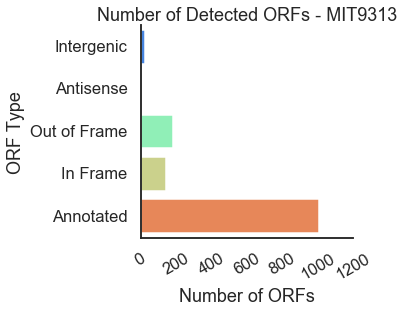

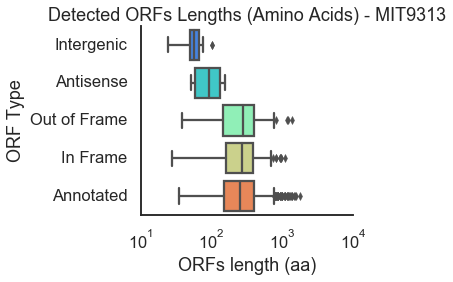

In [109]:
sns.catplot(data=merge_df.loc[merge_df.ms_detected],
             y='otype', kind='count', aspect=1.4, height=4,
       order=oorder, palette=opalette
           )
plt.xticks(rotation=30) 
plt.ylabel('ORF Type')
plt.xlabel('Number of ORFs')
plt.title(f'Number of Detected ORFs - {genome}')

sns.catplot(data=merge_df.loc[merge_df.ms_detected],
             y='otype', x='len_aa', aspect=1.4, height=4,
        kind='box',
       order=oorder, palette=opalette
           )
plt.xscale('log')
plt.ylabel('ORF Type')
plt.xlabel('ORFs length (aa)')

plt.title(f'Detected ORFs Lengths (Amino Acids) - {genome}')
plt.show()
    